# Introduction
This notebook provides a gentle introduction to the concept of anchor boxes used in Object Detection. You are expected to have attended the lecture (or watched its recording) before you go through this notebook.

The notebook is designed to help you understand how anchor boxes work and how one can use the anchor box generator in PyTorch to generate anchor boxes.

### Feedback
Please consider answering the following short survey once you're done going through the notebook, even if you've only partially used the notebook. The survey will take **less than 5 minutes** to complete, and it'll help us a lot in creating more teaching material and improving the existing one:
[https://nettskjema.no/a/jupyter](https://nettskjema.no/a/jupyter)

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from seaborn import color_palette

## Anchor boxes
Object detection methods give us bounding boxes around objects. It is hard to get a model to output a bounding box directly. What most object detection methods do instead is that they adjust some pre-defined bounding boxes. So, instead of trying to find a box from scratch, they are provided with a bounding box, and their job is to modify the bounding box. These pre-defined bounding boxes are called *anchor boxes* or *default boxes*. In this notebook, we will see how to get these anchor boxes for a given image and a feature map.

### Anchor boxes on a feature map
After an image has been processed through a model (say ResNet50), we get a feature map of a certain height and width (the number of channels in the feature map is irrelevant to our discussion here). If the feature map's width = height = 8, then the feature map has 8x8 = 64 elements (ignoring the \#channels). Each of these 64 elements has a *receptive field*. Please refer to the earlier lecture notes if you don't remember what a receptive field is. But to recap briefly, a receptive field refers to all the pixels in the image that the element in the feature map is connected to or think of it as all the pixels that the element has information about or, simply speaking, the part of the image that the element has "seen".

Each element of the feature map generates bounding boxes for its respective receptive field. A feature map early in the network has a smaller receptive field than the one later. This is why object detection models typically downsample a feature map multiple times to get more feature maps with different receptive field sizes to detect objects of varying sizes. But for simplicity, we'll focus on just one feature map in this notebook.

To get the portion of the image for which an element (of a feature map) will generate bounding boxes, we simply divide the image into equal portions such that each element gets assigned the same number of pixels. So, if the image's dimensions are (256 x 256) and that of the feature map are 8 x 8, then each element of the feature map will generate anchor boxes for a ((256/8) x (256/8)) = (32 x 32) portion of the image.

Let's visualise what we just discussed. In the image below, the blue rectangle represents our input image of size 256 x 256. For a feature map of size 8 x 8, we draw 64 red rectangles on the image representing the part of the image that those 64 elements will generate bounding boxes for.

In [2]:
# Let's first start by defining a function that we can later re-use.
def plot_image_with_rectangles(
    fig=None, ax=None,
    image_size=256,
    feature_map_size=8,
    extra_grid=32,
    rectangles=None,
    draw_image_on_top=False,
    rect_colour=None,
    title='' 
):
    """
    Plots an image with rectangles and returns the plot for further customization.
    Can be called multiple times to overlay new rectangles.
    
    Parameters:
        fig, ax (optional): Matplotlib figure and axis objects to update an existing plot.
        image_size (int): Size of the square image.
        feature_map_size (int): Determines the stride and grid size.
        extra_grid (int): Extra space around the image for better visibility.
        rectangles (list of tuples): Rectangles to draw in the format [(x1, y1, x2, y2), ...].
        draw_image_on_top (bool): Whether to draw the image (blue rectangle) over the rectangles.
        rect_colour: Colour to be used for drawing rectangles.
        title (str): Title of the plot.
        
    Returns:
        tuple: (fig, ax) Matplotlib figure and axis objects for further customization.
    """
    # Default colours
    palette = color_palette("muted", n_colors=10)
    image_colour = palette[0]  # Blue-like
    if rect_colour is None:
        rect_colour = palette[1]  # Red-like

    # If no existing figure/axis is provided, create a new one
    if fig is None or ax is None:
        sns.set_theme(style="whitegrid")
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(-extra_grid, image_size + extra_grid)
        ax.set_ylim(-extra_grid, image_size + extra_grid)
        ax.invert_yaxis()  # Invert y-axis for top-left origin
        
        # Draw gridlines
        ax.set_xticks(range(-extra_grid, image_size + extra_grid, 32))
        ax.set_yticks(range(-extra_grid, image_size + extra_grid, 32))
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.xaxis.tick_top()
        ax.grid(which='both', color='lightgrey', linestyle='--', linewidth=0.5)
    
    # Draw the image boundary (blue rectangle)
    image_patch = patches.Rectangle(
        (0, 0), image_size, image_size,
        edgecolor=image_colour, facecolor='none', lw=2
    )
    if not draw_image_on_top:
        ax.add_patch(image_patch)  # Draw below the rectangles

    # Draw rectangles
    if rectangles:
        for rect in rectangles:
            x1, y1, x2, y2 = rect
            width, height = x2 - x1, y2 - y1
            ax.add_patch(patches.Rectangle(
                (x1, y1), width, height,
                edgecolor=rect_colour, facecolor='none', lw=2
            ))

    # Optionally draw the image rectangle on top
    if draw_image_on_top:
        ax.add_patch(image_patch)

    # Add labels and title if this is the first plot
    if fig is not None and ax is not None and ax.title.get_text() == "":
        if title:
            ax.set_title(title, fontsize=16, pad=20)
        ax.set_xlabel("X-axis", fontsize=14)
        ax.set_ylabel("Y-axis", fontsize=14)
        ax.xaxis.set_label_position('top')
    
    return fig, ax

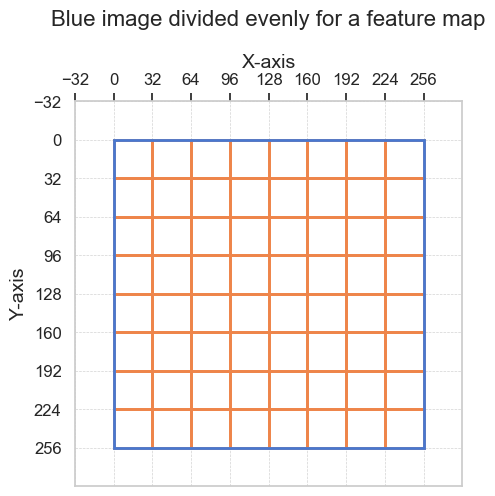

In [3]:
# Now let's draw an image (blue colour) of size (256, 256) and divide it into an equal number of parts (orange colour)
# where Number of parts = Number of elements in the feature map. So, each orange box corresponds to an area of the image
# to which an element in the feature map is assigned.
image_size = 256
feature_map_size = 8
stride = image_size // feature_map_size
rectangles = [(i * stride, j * stride, (i+1) * stride, (j+1) * stride) 
              for i in range(feature_map_size) 
              for j in range(feature_map_size)]

# Call the function for the first time
fig, ax = plot_image_with_rectangles(
    image_size=image_size, 
    feature_map_size=feature_map_size, 
    rectangles=rectangles,
    draw_image_on_top=True,
    title='Blue image divided evenly for a feature map'
)

The blue rectangle above is the image and orange rectangles in the image represent different parts of the image. Each of these parts will have its own set of anchor boxes centred around the top-left corner of the part. There are 8 x 8 = 64 parts in this image. If each part is used to define 2 anchor boxes then we'll have 64 x 2 = 128 anchors in total.

### Given the dimensions of the image, feature map, and anchor, generate anchor boxes
Now, let's write some code to generate these anchor boxes. The function below takes the dimensions as input and returns a list of anchor boxes on the image. The total number of anchors returned is equal to the number of elements in the feature map. If we wanna generate multiple anchors (of varying sizes) for each part of the image, then we can call this function multiple times with different arguments. Each anchor returned is a tuple of 4 values representing the top-left corner and the bottom-right corner of the anchor box. These values correspond to the pixel values in the input image.

In [4]:
def get_anchors(feature_map_size, image_size, anchor_size):
    anchor_boxes = []
    # Stride = Size of the portion of the image that an element in the feature map will generate anchor boxes for
    stride = (image_size[0] // feature_map_size[0], image_size[1] // feature_map_size[1])
    for i in range(feature_map_size[0]):
        for j in range(feature_map_size[1]):
            top_left = (i*stride[0], j*stride[1]) # Top Left corner of the receptive field
            # Get the top left and bottom right coordinates of the anchor box
            left = top_left[0] - (anchor_size[0] // 2)
            top = top_left[1] - (anchor_size[1] // 2)
            right = top_left[0] + (anchor_size[0] // 2)
            bottom = top_left[1] + (anchor_size[1] // 2)

            anchor_boxes.append((left, top, right, bottom))
    return anchor_boxes

Now let's call this function to get some anchor boxes and then plot them to see what they look like

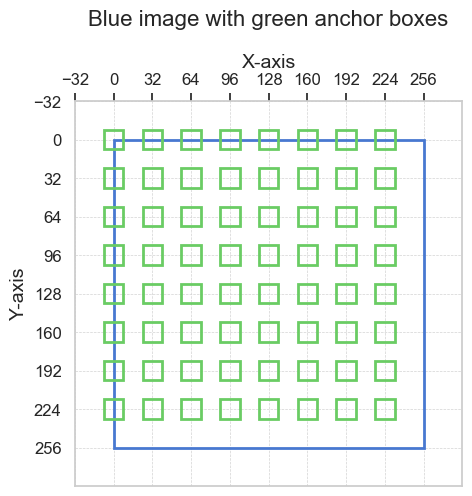

In [5]:
image_size = 256
feature_map_size = 8
anchor_box_size = 16
anchor_boxes = get_anchors((feature_map_size, feature_map_size), (image_size, image_size), (anchor_box_size, anchor_box_size))

palette = color_palette("muted", n_colors=10)
rect_colour = palette[2]

fig, ax = plot_image_with_rectangles(
    image_size=image_size, 
    feature_map_size=feature_map_size, 
    rectangles=anchor_boxes,
    draw_image_on_top=False,
    rect_colour=rect_colour,
    title='Blue image with green anchor boxes'
)

Green rectangles are the anchor boxes. Note how they are centred around the top-left corner of their respective "feature map areas" we drew earlier. This is how PyTorch's AnchorGenerator (which we'll use later) generates anchor boxes. If the object is elsewhere in the image, the model will move the anchor box accordingly and also adjust its size to cover it.

Now, let's get some more anchor boxes of a different size and draw only some of them to avoid overcrowding the image.

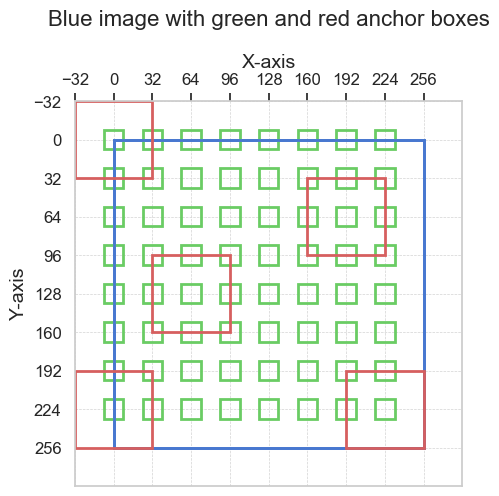

In [6]:
anchor_box_size = 64
anchor_boxes_size64 = get_anchors((feature_map_size, feature_map_size), (image_size, image_size), (anchor_box_size, anchor_box_size))
indices_to_keep = [0, 7, 20, 50, 63]

# First, plot the previous anchor boxes
palette = color_palette("muted", n_colors=10)
rect_colour = palette[2]
fig, ax = plot_image_with_rectangles(
    image_size=image_size,
    feature_map_size=feature_map_size,
    rectangles=anchor_boxes,
    draw_image_on_top=False,
    rect_colour=rect_colour
)

# Now, we'll plot some of the new ones
rect_colour = palette[3]
fig, ax = plot_image_with_rectangles(
    fig=fig, ax=ax,
    image_size=image_size,
    feature_map_size=feature_map_size,
    rectangles=[anchor_boxes_size64[i] for i in indices_to_keep],
    draw_image_on_top=False,
    rect_colour=rect_colour,
    title='Blue image with green and red anchor boxes'
)

# # Explicitly display the updated figure
# from IPython.display import display
# display(fig)

The new rectangles you see are some of the new anchor boxes of size (64, 64). They don't have to be square in shape. Feel free to play around with various dimensions and see what the anchor boxes look like and what area do they cover on the image.

These larger anchor boxes can be used to detect larger objects. Typically, you'd want to detect smaller objects on the feature maps with smaller receptive fields and larger objects using the feature maps with large receptive fields. We're using only 1 feature map here for simplicity.

## Torchvision's anchor generator
Now, we'll see how we can use Torchvision's AnchorGenerator class that it uses to generate anchor boxes.

While our implementation of the function for generating anchor boxes was simple and easy to understand, it was not efficient. Torchvision's implementation is more efficient and gives a (sort of) similar output to ours, but it defines anchors' sizes in a very different way which I'll explain next. You can check out the AnchorGenerator's code here: https://github.com/pytorch/vision/blob/release/2.0/torchvision/models/detection/anchor_utils.py#L10-L133

### Defining anchor box's size using "scale" and "aspect ratio"
Torchvision (and other code bases/libraries in general like Tensorflow) uses 2 parameters to define the anchor size: scale(size) and aspect ratio. Aspect ratio is simply the ratio of height and width: $Aspect\ Ratio = \frac{height}{width}$. Scale is used with aspect ratio to define height and width as: $height = scale\times\sqrt{aspect\ ratio}$ and $width = \frac{scale}{\sqrt{aspect\ ratio}}$. If you divide height by width, you'll get aspect ratio, which is exactly what we want. $\frac{height}{width}=\frac{scale\times\sqrt{aspect\ ratio}}{\frac{scale}{\sqrt{aspect\ ratio}}}=aspect\ ratio$

Check the function `generate_anchors` in Torchvision's code link above. It does exactly what I just explained.

### Finally, let's use the AnchorGenerator class and plot the anchors
Now that you understand what the parameters in the Torchvision's `AnchorGenerator` class mean, let's go ahead and use the class to generate some anchor boxes and then visualise them like we did. Let's see if we can manage to generate the same anchors as we did above but this time using `AnchorGenerator`. Note that `AnchorGenerator` refers to "scales" as "sizes" in its init method but if you look at the `__init__` function, you'll see that it simply calls the `generate_anchors` method using "size" as "scale".

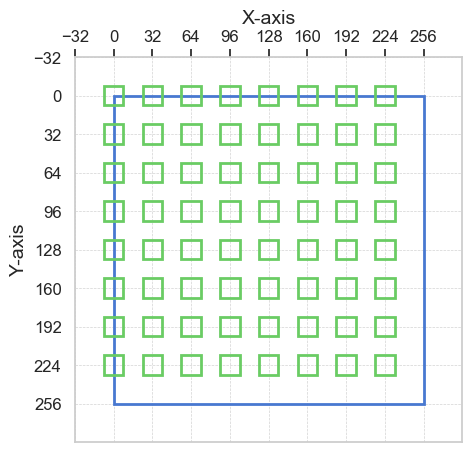

In [7]:
from torchvision.models.detection.anchor_utils import AnchorGenerator

p_anchor_generator = AnchorGenerator(((16,)), ((1.,)))
# Instead of calling the forward function, which requires images as input, we'll directly call the 
# grid_anchors method that the forward function calls internally to generate anchors:
# https://github.com/pytorch/vision/blob/release/2.0/torchvision/models/detection/anchor_utils.py#L127
p_anchors = p_anchor_generator.grid_anchors([[feature_map_size, feature_map_size]], [[torch.tensor(stride), torch.tensor(stride)]])
p_anchors = [tuple(i) for i in p_anchors[0].numpy()]

rect_colour = palette[2]
fig, ax = plot_image_with_rectangles(
    image_size=image_size,
    feature_map_size=feature_map_size,
    rectangles=p_anchors,
    draw_image_on_top=False,
    rect_colour=rect_colour
)

So, we got the same anchor boxes that we plotted above using our simplified function. Notice that we passed the aspect ratio as 1.0 in the constructor because we want to draw square boxes. You can instantiate `AnchorGenerator` with not just 1 but multiple scales and aspect ratios and `AnchorGenerator` will use all combinations of scales and aspect ratios for anchor boxes (check the constructor `__init__` in the code link above).

You can try and plot the bigger anchor boxes that we plotted earlier.

Let's now make the anchor boxes slightly bigger but change the aspect ratio to 2.0. Aspect ratio 2.0 should result in boxes whose height is twice their width. These boxes could be used for detecting pedestrians for example. You can also try to change the aspect ratio to 0.5 to draw anchor boxes that could be used for detecting other things like cars.

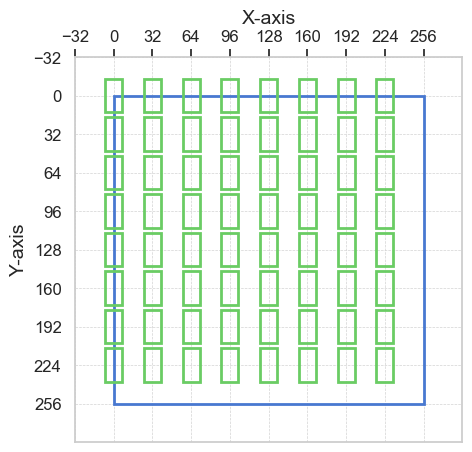

In [8]:
p_anchor_generator = AnchorGenerator(((20,)), ((2.,)))
p_anchors = p_anchor_generator.grid_anchors([[feature_map_size, feature_map_size]], [[torch.tensor(stride), torch.tensor(stride)]])
p_anchors = [tuple(i) for i in p_anchors[0].numpy()]

rect_colour = palette[2]
fig, ax = plot_image_with_rectangles(
    image_size=image_size,
    feature_map_size=feature_map_size,
    rectangles=p_anchors,
    draw_image_on_top=False,
    rect_colour=rect_colour
)

## Wrapping up
I hope this notebook helped you better understand anchor boxes AND see how you can practically use them using Torvision's `AnchorGenerator`.

Anchors are only one of the many components in an object detection pipeline, although probably the most challenging component to understand. If you're interested in learning how to use the whole object detection pipeline in PyTorch (using Torchvision), then please go to the Torchvision's tutorial here: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

If you find any bugs or mistakes in this notebook, then please send me an email (or a message on Mattermost) to help me improve it.

### Feedback
Please consider answering the following short survey even if you've only partially used the notebook. The survey will take **less than 5 minutes** to complete, and it'll help us a lot in creating more teaching material and improving the existing one:
[https://nettskjema.no/a/jupyter](https://nettskjema.no/a/jupyter)